<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/reetu/pca_clinical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
def fill_death_col(clinical_data):
  
  male_obese = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] > 30)
  female_obese = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] > 30)
  male_underweight = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] < 18.5)
  female_underweight = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] < 18.5)
  clinical_data['BMI_reduction_factor'] = 0
  clinical_data.loc[male_obese, 'BMI_reduction_factor'] = 4.2
  clinical_data.loc[female_obese, 'BMI_reduction_factor'] = 3.5
  clinical_data.loc[male_underweight, 'BMI_reduction_factor'] = 4.3
  clinical_data.loc[female_underweight, 'BMI_reduction_factor'] = 4.5

  clinical_data['Tobacco_reduction_factor'] = np.where(clinical_data['Tobacco']==1,10,0)

  
  #Leave na on rows with no death data, fill the rest with age*365+death days 
  clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT']*365 + clinical_data['DEATH [d from CT]'])
  
  # fill death with avg lifespan - alpha(reduction for tobacco) - beta(reduction for bmi)
  corr_bmi_death = clinical_data['BMI'].corr(clinical_data['Age_at_death'])
  corr_tobacco_death = clinical_data['Tobacco'].corr(clinical_data['Age_at_death'])

  # print(corr_bmi_death)
  # print(corr_tobacco_death)

  #normalize
  alpha = corr_bmi_death/(corr_bmi_death+corr_tobacco_death)
  beta = corr_tobacco_death/(corr_bmi_death+corr_tobacco_death)

  # print(alpha)
  # print(beta)
  
  avg_lifespan_male=76.3  
  avg_lifespan_female=81.2

  clinical_data['avg_life'] = np.where(clinical_data['Sex']==1, avg_lifespan_male, avg_lifespan_female)
  clinical_data['avg_life'] = clinical_data['avg_life'] - alpha*(clinical_data['BMI_reduction_factor'])-beta*(clinical_data['Tobacco_reduction_factor'])
  clinical_data['DEATH [d from CT]'].fillna((clinical_data['avg_life']-clinical_data['Age at CT'])*365, inplace=True)
  
  clinical_data.drop(columns=['Age_at_death'], inplace=True) #only used for correlation, we dont need this any further
  return clinical_data


In [5]:
def preprocess_clinical_data(oppScrData, mean=True):
    clinical_data = oppScrData.filter(['BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
                                'FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)', 'DEATH [d from CT]' , 'Age at CT'], axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage 
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 
  
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
 
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    clinical_data = fill_death_col(clinical_data)

    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [6]:
def normalize_ss(data):
  return StandardScaler().fit_transform(data)

In [7]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx') 
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)

Cumulative Variances (Percentage):
[31.43941673 54.11477215 70.71397677 84.09276659 90.5008666 ]
Number of components: 5


Text(0, 0.5, 'Explained variance (%)')

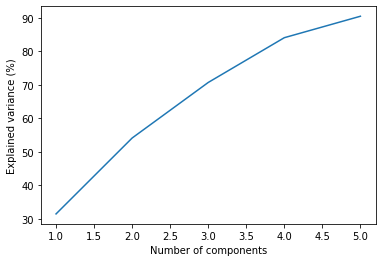

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = clinical_data.drop(columns=['DEATH [d from CT]'])
X_scaled = normalize_ss(X)

pca = PCA(n_components = 0.90)
pca.fit(X_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [9]:
pca_components = abs(pca.components_)
print('Top 4 most important features in each component')
print('===============================================')
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {clinical_data.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['Tobacco_reduction_factor', 'Age at CT', 'BMI >30', 'BMI']
Component 1: ['DEATH [d from CT]', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRAX 10y Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)']
Component 2: ['FRAX 10y Fx Prob (Orange-w/ DXA)', 'Sex', 'BMI >30', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)']
Component 3: ['Tobacco', 'BMI_reduction_factor', 'Sex', 'FRS 10-year risk (%)']
Component 4: ['Met Sx', 'Age at CT', 'BMI >30', 'FRS 10-year risk (%)']


In [10]:
X_pca = pca.transform(X_scaled)
print(X_pca.shape)
print(X_pca)

(9223, 5)
[[-2.40793019  0.19380515  1.58202477  1.83815172 -1.27579571]
 [-0.59747802 -1.29725168  1.41160914  0.12166676 -0.72832731]
 [ 1.58181341 -1.28706956 -0.05758322  0.16026961  0.24949712]
 ...
 [-1.9243948  -1.02299052  3.51723561 -0.27585987  2.28419231]
 [ 1.92496364 -1.19437136  0.28618717  0.04124767  0.14021224]
 [ 0.97583751  0.11991154 -0.86325598  1.84475937  0.15914366]]
